# Linear Regression

This is the second programming assignment for CSCE478/878 Introduction to Machine Learning on Linear Regression. This notebook is divided into 3 sections, namely
1. **Part A (Model Code)**
1. **Part B (Data Processing)**
1. **Part C (Model Evaluation)**

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import itertools
import math

## Part A

### 1. Implement the following function that generates the polynomial and interaction features for a given degree of the polynomial

In [154]:
"""
Takes the feature matrix X and the polynomial degree and returns
X with features of polynomial degrees and pairwise interaction
terms

Input:
    X - 2D np.ndarray feature matrix
    degree - integer > 0
    
Output:
    X - 2D np.ndarray polynomial feature matrix 
"""
# Doesn't Include the Bias Term, as it will be added in the regression functions
def polynomialFeatures(X, degree):
    
    #X_original=X.copy()
    # Create polynomials of degree n
    #if degree > 1:
        #for d in range(2, degree+1):
            # Create combinations of interaction terms
            #interactions =  lambda x: np.multiply.reduce(np.array(list(itertools.combinations_with_replacement(x.T,d))),1).T
            #X = np.concatenate((X,interactions(X_original)), axis=1)
    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(degree)
    X=poly.fit_transform(X)
    return X

### 2. Implement the following function to calculate and return the mean squared error (mse) of two vectors.
 

In [26]:
"""
Calculates the mean squared error (mse) between the true and predicted labels
Input: 
    true: array_like type vector of true labels
    pred: array_like type vector of predicted labels
Output:
    mean squared error: accuracy expressed in decimal
"""
def MSE_error(true,pred):
    diff = true - pred
    error = np.dot(diff,diff)/true.shape[0]
    return error

###  3. Implement the following function to plot the training and validation root mean square error (rmse) values of the data matrix X for various polynomial degree starting from 1 up to the value set by the argument “maxPolynomialDegree” 

In [231]:
def plot_polynomial_model_complexity(estimator,X,y,cv,max_degree):
    
    range_degree=np.array([d for d in range(1,max_degree+1)]) 
    X_original=X.copy()
    avg_score_train=[]
    avg_score_val=[]
    #Running for every degree
    for d in range(1,max_degree+1):
        
        X2=polynomialFeatures(X_original,d)
        size = len(X2)
        size_fold = int(size/cv)
        range_index = [j for j in range(0,len(X2))]
        score_val=[]
        score_train=[]
        #Data Standardization
        r,c=np.shape(X2)
        for col in range(0,c):
            m=np.mean(X2[:,col])
            s=np.std(X2[:,col])
            if s>0:
                X2[:,col]=(X2[:,col]-m)/s
    #Partitioning of the data    
        for i in range(cv):
            init=0+i*size_fold
            fin=(i+1)*size_fold
            partition_range_index = [j for j in range(init,fin)]
            
            #Feature and label data of the Fold
            X_partition = X2[partition_range_index]
            y_partition = y[partition_range_index]
            
            #Feature and label data of  1-Fold        
            remainder_index = list(set(range_index).difference(set(partition_range_index)))
            X_remainder=X2[remainder_index]
            y_remainder=y[remainder_index]
            
            #Fit the model to the 1-Fold data
            estimator.fit(X_remainder, y_remainder)
            
            #Test the model on the 1-Fold data
            pred=estimator.predict(X_remainder)
            rmse=math.sqrt(MSE_error(y_remainder,pred))
            score_train.append(rmse) 
            
            #Test the model on the fold data
            pred=estimator.predict(X_partition)
            rmse=math.sqrt(MSE_error(y_partition,pred))
            score_val.append(rmse) 
        avg_score_train.append(np.mean(score_train))
        avg_score_val.append(np.mean(score_val))
    
           
    #generate the plot
    plt.figure()
    plt.plot(range_degree,avg_score_train)
    plt.plot(range_degree,avg_score_val)
    plt.xlabel("Polynomial Degree")
    plt.ylabel("RMSE")
    plt.title('Polynomial Model Complexity')
    plt.legend(["Training", "Validation"])
    return 
    

In [201]:
'''
Linear Regression that takes optional hyperparameters. Contains methods fit using Batch Gradient Descent to
estimate the weight parameters of the model.
Methods:
    fit - Given X and y, using batch gradient descent to find w
    predict - Given X, using w to provide prediction
'''
class Linear_Regression():
    def __init__(self, learning_rate=0.01, epochs=100, tol=None, regularizer=None, lambd=0.0, **kwargs):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.tol = tol
        self.regularizer = regularizer
        self.lambd = lambd
        self.w = None
        
        return
    
    def fit(self, X, y):
        # Add x_0 = 1 for all for intercept and concat data
        x_0 = np.ones((X.shape[0],1))
        X = np.concatenate((x_0,X), axis=1)
        
        # Init prev_cost with 0
        prev_cost = 0
        
        # Number of training samples
        m = len(X)
        # Initialize all weights to 0
        self.w = np.zeros((X.shape[1],))
        
        # Run batch gradient descent up to self.epoch times
        for i in range(self.epochs):
            # Calculate mse with current weights
            new_cost=0.5*MSE_error(X.dot(self.w),y)
            
            if self.regularizer == "l2":
                regularized_term = 0.5*self.lambd*np.dot(self.w[1:],self.w[1:])/m # Exclude the bias term
                new_cost=new_cost + regularized_term
                
            elif self.regularizer == 'l1':
                regularized_term = 0.5*self.lambd*np.sum(abs(self.w[1:]))/m  # Exclude the bias term
                new_cost=new_cost + regularized_term
            
            # Break if absolute cost of previous cost and current cost is smaller than self.tol
            if self.tol is not None:
                if abs(prev_cost - new_cost) > self.tol:
                    prev_cost = new_cost
                else:
                    break
            
            # Calculate gradient
            grad = (X.T.dot(X.dot(self.w)-y))
            
            # Apply Regularization term to gradient
            if self.regularizer == "l2":
                regularized_term = self.lambd*self.w
                regularized_term[0] = 0 # Exclude the bias term
                grad = grad + regularized_term
                
            elif self.regularizer == 'l1':
                regularized_term = self.lambd * np.sign(self.w)
                regularized_term[0] = 0 # Exclude the bias term
                grad = grad + regularized_term
            
            # Update weights
            self.w = self.w - (self.learning_rate/m)*grad
            
    def predict(self, X):
        
        x_0 = np.ones((X.shape[0],1))
        X = np.concatenate((x_0,X), axis=1)
        
        pred = X.dot(self.w)
        
        return pred


## Part B

### 5. Read in the winequality-red.csv file as a Pandas data frame.

In [42]:
df = pd.read_csv('./Data/winequality-red.csv', sep=';')

### 6. Use the techniques from the recitation to summarize each of the variables in the dataset in terms of mean, standard deviation, and quartiles. Include this in your report.

In [31]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


### 7. Shuffle the rows of your data. You can use def = df.sample(frac=1) as an idiomatic way to shuffle the data in Pandas without losing column names. Create a test dataset by randomly sampling 20% of the data. Remaining data should be used for training.

In [185]:
df = df.sample(frac=1)

In [186]:
def partition(X, y, t):
    # Determine sizes of sample, training and test set
    n = len(y)
    size_train = int(t * n)
    size_test = 1 - size_train
    
    # Generate list of all index
    range_index = [x for x in range(0,n)]
    # Generate list of random index with the size of training set
    train_index = random.sample(range(0, n), size_train)
    # Obtain the set difference between all the training for test 
    test_index = list(set(range_index).difference(set(train_index)))
    
    # Subsetting train and test
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    
    return X_train, X_test, y_train, y_test

In [187]:
X = np.array(df.drop(columns=['quality'],axis=1))
y = np.array(df['quality'])

In [188]:
X_train, X_test, y_train, y_test = partition(X, y, 0.8)

In [189]:
# Data Standardization
r,c=np.shape(X_train)
for col in range(0,c):
    m=np.mean(X_train[:,col])
    s=np.std(X_train[:,col])
    X_train[:,col]=(X_train[:,col]-m)/s
    # standardize test Data on the mean and sd of Train Data  
    X_test[:,col]=(X_test[:,col]-m)/s

## Part C

### 8. Model selection via Hyperparameter tuning: Use the kFold function (known as sFold function from previous assignment) to evaluate the performance of your model over each combination of lambd, learning_rate and regularizer hyperparameters from the following sets:

In [45]:
def sFold(estimator,X,y,scoring,cv):
    size = len(X)
    size_fold = int(size/cv)
    range_index = [j for j in range(0,len(X))]
    score=[]
    #Partitioning of the data
    for i in range(cv):
        init=0+i*size_fold
        fin=(i+1)*size_fold
        partition_range_index = [j for j in range(init,fin)]
        
        #Feature and label data of the Fold
        X_partition = X[partition_range_index]
        y_partition = y[partition_range_index]
        
        #Feature and label data of  1-Fold        
        remainder_index = list(set(range_index).difference(set(partition_range_index)))
        X_remainder=X[remainder_index]
        y_remainder=y[remainder_index]
        
        #Fit the model to the 1-Fold data
        estimator.fit(X_remainder, y_remainder) 
        
        #Test the model on the fold data
        pred=estimator.predict(X_partition)
        if scoring=='MSE':
            mse=MSE_error(y_partition,pred)
            score.append(mse) 
            
    avg_score = np.mean(score)    
    return avg_score,score

In [ ]:
lambd =[1.0,0,0.1,0.01,0.001,0.0001] 
epoch=[1000,10000]
learning_rate =[0.1, 0.01, 0.001, 0.001]
regularizer = ['l1', 'l2']
cv=10

results = {}

for lam in lambd:
    for epo in epoch:
        for eta in learning_rate:
            for reg in regularizer:
                label ='Lambda'+'_'+str(lam) + '_'+'Learning Rate'+'_'+ str(eta) +'_'+'Regularizer'+'_'+str(reg)+'_'+'Epochs'+'_'+ str(epo)
                model=Linear_Regression(learning_rate = eta, epochs = epo, regularizer = reg, lambd = lam)
                results[label] = sFold(model,X_train,y_train,scoring='MSE',cv=cv)
            
print(results)

In [ ]:
min_MSE =100000000
min_config = ''
for key,pair in results.items():
    print(key + ": MSE Error " + str(pair[0]))
    if pair[0] <min_MSE:
        min_MSE=pair[0]
        min_config=key
print(min_MSE)
print(min_config)

### 9. Evaluate your model on the test data and report the mean squared error.
 

In [66]:
#Best Model
#Regularizer: L2
#Learning Rate: 0.001
#Lambda: 1
#Epochs: 10000

model = Linear_Regression(learning_rate = 0.001, epochs = 10000, regularizer = 'l2', lambd = 1)
model.fit(X_train, y_train)
pred=model.predict(X_test)

#MSE
mse=MSE_error(y_test,pred)
print("\nMSE: %0.3f" %mse)


MSE: 0.444


### 10. Determine the best model hyperparameter values for the training data matrix with polynomial degree 3.


In [183]:
lambd =[1.0,0,0.1,0.01,0.001,0.0001] 
epoch=[1000,10000]
learning_rate =[0.1, 0.01, 0.001, 0.001]
regularizer = ['l1', 'l2']
cv=10
X2=polynomialFeatures(X,3)
X_train2, X_test2, y_train2, y_test2 = partition(X2, y, 0.8)
#Data Standardization
r,c=np.shape(X_train2)
for col in range(0,c):
    m=np.mean(X_train2[:,col])
    s=np.std(X_train2[:,col])
    if s>0:
        X_train2[:,col]=(X_train2[:,col]-m)/s

results = {}

for lam in lambd:
    for epo in epoch:
        for eta in learning_rate:
            for reg in regularizer:
                label ='Lambda'+'_'+str(lam) + '_'+'Learning Rate'+'_'+ str(eta) +'_'+'Regularizer'+'_'+str(reg)+'_'+'Epochs'+'_'+ str(epo)
                model=Linear_Regression(learning_rate = eta, epochs = epo, regularizer = reg, lambd = lam)
                results[label] = sFold(model,X_train2,y_train2,scoring='MSE',cv=cv)
            
print(results)

<ipython-input-44-def89ad25e6f>:42: RuntimeWarning: invalid value encountered in double_scalars
  regularized_term = 0.5*self.lambd*np.sum(abs(self.w[1:]))/m  # Exclude the bias term
<ipython-input-44-def89ad25e6f>:38: RuntimeWarning: invalid value encountered in double_scalars
  regularized_term = np.array(0.5*self.lambd*np.dot(self.w[1:],self.w[1:])/m) # Exclude the bias term
<ipython-input-44-def89ad25e6f>:57: RuntimeWarning: invalid value encountered in multiply
  regularized_term = self.lambd*self.w


{'Lambda_1.0_Learning Rate_0.1_Regularizer_l1_Epochs_1000': (nan, [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), 'Lambda_1.0_Learning Rate_0.1_Regularizer_l2_Epochs_1000': (nan, [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), 'Lambda_1.0_Learning Rate_0.01_Regularizer_l1_Epochs_1000': (0.40843922677862593, [0.3558901679030535, 0.3841146614811492, 0.4489019194989011, 0.31347313116947373, 0.5426043955051693, 0.4314073926025395, 0.42077850063603156, 0.4076645078686741, 0.36146795051345715, 0.4180896406078099]), 'Lambda_1.0_Learning Rate_0.01_Regularizer_l2_Epochs_1000': (0.4107186475183342, [0.3557717077229644, 0.3865429144026475, 0.4476250258553494, 0.3137050840853435, 0.5512466937149707, 0.43292030036418244, 0.418119973475099, 0.4178993881270017, 0.3666989310646684, 0.41665645637111487]), 'Lambda_1.0_Learning Rate_0.001_Regularizer_l1_Epochs_1000': (1.0451403350423316, [1.0557435266637147, 1.030081827187974, 0.9486713002710825, 0.9880920961045374, 1.1863889086389852, 1.036869

In [184]:
min_MSE =100000000
min_config = ''
for key,pair in results.items():
    print(key + ": MSE Error " + str(pair[0]))
    if pair[0] <min_MSE:
        min_MSE=pair[0]
        min_config=key
print(min_MSE)
print(min_config)

Lambda_1.0_Learning Rate_0.1_Regularizer_l1_Epochs_1000: MSE Error nan
Lambda_1.0_Learning Rate_0.1_Regularizer_l2_Epochs_1000: MSE Error nan
Lambda_1.0_Learning Rate_0.01_Regularizer_l1_Epochs_1000: MSE Error 0.40843922677862593
Lambda_1.0_Learning Rate_0.01_Regularizer_l2_Epochs_1000: MSE Error 0.4107186475183342
Lambda_1.0_Learning Rate_0.001_Regularizer_l1_Epochs_1000: MSE Error 1.0451403350423316
Lambda_1.0_Learning Rate_0.001_Regularizer_l2_Epochs_1000: MSE Error 1.0502697677708228
Lambda_1.0_Learning Rate_0.1_Regularizer_l1_Epochs_10000: MSE Error nan
Lambda_1.0_Learning Rate_0.1_Regularizer_l2_Epochs_10000: MSE Error nan
Lambda_1.0_Learning Rate_0.01_Regularizer_l1_Epochs_10000: MSE Error 0.4269424693082679
Lambda_1.0_Learning Rate_0.01_Regularizer_l2_Epochs_10000: MSE Error 0.4393846104179566
Lambda_1.0_Learning Rate_0.001_Regularizer_l1_Epochs_10000: MSE Error 0.40843933346152583
Lambda_1.0_Learning Rate_0.001_Regularizer_l2_Epochs_10000: MSE Error 0.41071612259906676
Lambda_

### 11. Using the plot_polynomial_model_complexity function plot the rmse values for the training and validation folds for polynomial degree 1, 2, 3, 4 and 5. Use the training data as input for this function. You need to choose the hyperparameter values judiciously to work on the higher-degree polynomial models.

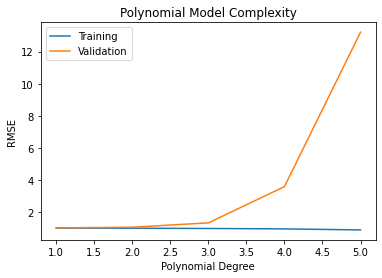

In [232]:
model = Linear_Regression(learning_rate = 0.001, epochs = 1000, regularizer = 'l2', lambd = 1)
plot_polynomial_model_complexity(model,X_train,y_train,5,5)

### 12. Implement the Stochastic Gradient Descent Linear Regression algorithm. 

In [21]:
'''
Linear Regression that takes optional hyperparameters. Contains methods fit using Stochastic Gradient Descent to
estimate the weight parameters of the model.
Methods:
    fit - Given X and y, using Stochastic gradient descent to find theta
    predict - Given X, using theta to provide prediction
'''
class Stochastic_Gradient():
    def __init__(self, learning_rate=0.01, epochs=100, tol=None, regularizer=None, lambd=0.0, t0=5, t1=50, **kwargs):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.tol = tol
        self.regularizer = regularizer
        self.lambd = lambd
        self.theta = None
        self.t0=t0 # Hyperparameter for the Learning Schedule
        self.t1=t1 # Hyperparameter for the Learning Schedule
        return
    
    def fit(self, X, y):
        # Add x_0 = 1 for all for intercept and concat data
        x_0 = np.ones((X.shape[0],1))
        X = np.concatenate((x_0,X), axis=1)
        
        #Length of the Data
        n=len(X)
    
        # Init prev_cost with 0
        init_loss = 0
        
        # Initialize all weights to 0
        self.theta = np.zeros((X.shape[1],))
        
        # Learning Schedule
        def learning_schedule(t):
            #eta=self.t0/(t+self.t1)
            eta=self.learning_rate
            return eta
        
        # Run for every epoch
        for epoch in range(self.epochs):
    
        # Run for every data row
            for i in range(n):
                
                # Update Learning Rate
                self.learning_rate=learning_schedule(epoch*m+i)
                
                #Initialize Random Index
                random_index = np.random.randint(n)
                yi= y[random_index:random_index+1]
                xi=X[random_index:random_index+1]
    
                # Loss Calculation
                
                new_loss=0.5*MSE_error(xi.dot(self.theta),yi)
               
                if self.regularizer == "l2":
                    regularized_term = 0.5*self.lambd*np.dot(self.theta[1:],self.theta[1:]) # Exclude the bias term
                    new_loss = new_loss + regularized_term
                 
                elif self.regularizer == 'l1':
                    regularized_term = 0.5*self.lambd*np.sum(abs(self.theta[1:])) # Exclude the bias term
                    new_loss=new_loss + regularized_term
                    
                    
                # Break if absolute cost of previous cost and current cost is smaller than self.tol
                if self.tol is not None:
                    if abs(init_loss - new_loss) > self.tol:
                        init_loss = new_loss
                    else:
                        break
                        
                # Gradient computation
                grad = xi.T.dot(xi.dot(self.theta)-yi)
                
                # Gradient regularization
                if self.regularizer == "l2":
                    regularized_term = self.lambd*self.theta # Exclude the bias term
                    regularized_term[0] = 0
                    grad = grad + regularized_term
                    
                elif self.regularizer == 'l1':
                    regularized_term = self.lambd * np.sign(self.theta)# Exclude the bias term
                    regularized_term[0] = 0
                    grad = grad + regularized_term
            
            # New theta
            self.theta = self.theta - ((self.learning_rate)*grad)
            
    def predict(self, X):
        m=len(X)
        x_0 = np.ones((m,1))
        X = np.concatenate((x_0,X), axis=1)
        pred = np.dot(X,self.theta)
        
        return pred


In [ ]:
#Cross_Validation
lambd =[1.0,0,0.1,0.01,0.001,0.0001] 
epoch=[1000,100]
learning_rate =[0.1, 0.01, 0.001, 0.001]
regularizer = ['l1', 'l2']
cv=10

results = {}

for lam in lambd:
    for epo in epoch:
        for eta in learning_rate:
            for reg in regularizer:
                label ='Lambda'+'_'+str(lam) + '_'+'Learning Rate'+'_'+ str(eta) +'_'+'Regularizer'+'_'+str(reg)+'_'+'Epochs'+'_'+ str(epo)
                model=Stochastic_Gradient(learning_rate = eta, epochs = epo, regularizer = reg, lambd = lam)
                results[label] = sFold(model,X_train,y_train,scoring='MSE',cv=cv)
            
print(results)

In [ ]:
#Best Model
min_MSE =100000000
min_config = ''
for key,pair in results.items():
    print(key + ": MSE Error " + str(pair[0]))
    if pair[0] <min_MSE:
        min_MSE=pair[0]
        min_config=key
print(min_MSE)
print(min_config)

In [111]:
#Testing on the Test Matrix
#Best Model
#Regularizer: L2
#Learning Rate: 0.001
#Lambda: 1
#Epochs: 10000

model = Stochastic_Gradient(learning_rate = 0.01, epochs = 1000, regularizer = 'l2', lambd = 0.01)
model.fit(X_train, y_train)
pred=model.predict(X_test)

#MSE
mse=MSE_error(y_test,pred)
print("\nMSE: %0.3f" %mse)


MSE: 0.472
